In [3]:
import pandas as pd
import numpy as np
import math
import time
import warnings
warnings.filterwarnings("ignore")
import multiprocessing as mp

import seaborn as sns
import matplotlib.pyplot as plt
from sklearn.preprocessing import LabelBinarizer
from sklearn.preprocessing import PolynomialFeatures
from sklearn.linear_model import Ridge
from sklearn.pipeline import make_pipeline

import constant
import tools
import myplot 

# 1. Load Files

In [4]:
settlement = pd.read_parquet(constant.settlement_2019_path)
dtype = {"GSRN":str,"Parent_GSRN":str,"Turbine_type":str,"BBR_municipal":str,"Placement":str,"grid":str}
windmill = pd.read_csv(constant.windmill_path, dtype=dtype)

wu10 = pd.read_parquet(constant.wu10_path)
wv10 = pd.read_parquet(constant.wv10_path)
wu100 = pd.read_parquet(constant.wu100_path)
wv100 = pd.read_parquet(constant.wv100_path)

ws10 = pd.read_parquet(constant.ws10_path)
ws100 = pd.read_parquet(constant.ws100_path)
wd10 = pd.read_parquet(constant.wd10_path)
wd100 = pd.read_parquet(constant.wd100_path)

In [5]:
windmill_1 = windmill[windmill["GSRN"] == "570714700000004070"]
# windmill_2 = windmill[windmill["GSRN"] == "570714700000000348"]
windmill_2 = windmill[windmill["GSRN"] == "570714700000000317"]

### Aggregate windmill and settlement

In [6]:
df_1 = pd.merge(windmill_1, settlement, on="GSRN")
df_2 = pd.merge(windmill_2, settlement, on="GSRN")

# 2. Feature Extraction
## Extract Weather Data
Register grided weather data extration functions

In [7]:
def get_by_grid(df, g, t):
    try:
        return df[df['TIME_CET'] == t][g].tolist()[0]
    except:
        return 0

get_by_grid_wu10 = lambda g, t: get_by_grid(wu10, g, t)
get_by_grid_wv10 = lambda g, t: get_by_grid(wv10, g, t)
get_by_grid_wu100 = lambda g, t: get_by_grid(wu100, g, t)
get_by_grid_wv100 = lambda g, t: get_by_grid(wv100, g, t)
get_by_grid_ws10 = lambda g, t: get_by_grid(ws10, g, t)
get_by_grid_ws100 = lambda g, t: get_by_grid(ws100, g, t)
get_by_grid_tmp2 = lambda g, t: get_by_grid(tmp2, g, t)
get_by_grid_tmp100 = lambda g, t: get_by_grid(tmp100, g, t)

get_weather = lambda x, fun: fun(x["grid"], x["TIME_CET"])

## Extract Windshear
Extract Windshear in reverse by two layers 10m, 100m

In [8]:
from math import log
def windshear(v1, v2, z1, z2):
    """
    Calaulate windshear in reverse by two layers
    """
    a1 = abs(v1)
    a2 = abs(v2)
    if v1 < 0 and v2 >= 0 or v1 >= 0 and v2 < 0:
        a2 = a1 + a2

    a = log(a2/(a1+1e-06)+1e-06) / log(z2/z1)

    return a

"wsr_u": wind shear from wind_u_10m, wind_u_100m    
"wsr_v": wind shear from wind_v_10m, wind_v_100m    
"wsr": wind shear from wind_speed_10m, wind_speed_100m

## Interpolation Wind Speed to Hub height
by power law

In [9]:
pow_law = lambda v, z, z_hat, a : v * ( (z_hat/z) ** a) + 1e-06

In [10]:
get_ws_hub_r_u = lambda x,fun :fun(x["wu10"], 10, x["Navhub_height"], x["Roughness"])
get_ws_hub_r_v = lambda x,fun :fun(x["wv10"], 10, x["Navhub_height"], x["Roughness"])
get_ws_hub_wsr_u = lambda x,fun :fun(x["wu10"], 10, x["Navhub_height"], x["wsr_u"])
get_ws_hub_wsr_v = lambda x,fun :fun(x["wv10"], 10, x["Navhub_height"], x["wsr_v"])

get_ws_by_uv = lambda u, v : (u ** 2 + v ** 2) ** 0.5

## Extract quantiles

In [11]:
def extract_quantiles(df, feature, boundary=[]):

    def boundary_limit(df, f):
        df[f] = df[f].apply(lambda x: 0 if x < boundary[0] else boundary[1] if x > boundary[1] else x)
        df[f] = df[f].apply(lambda x: 0 if x < boundary[0] else boundary[1] if x > boundary[1] else x)

        try:
            index = df[df[f] == boundary[0]].index.values.astype(int)[0]
            for i in range(index):
                df.iloc[i][f] = boundary[0]
        except:
            pass

        try:
            index = df[df[f] == boundary[1]].index.values.astype(int)[0]
            for i in range(index, len(temp)):
                df.iloc[i][f] = boundary[1]
        except:
            pass

        return df

    temp = df[[feature, "VAERDI"]]
    temp[feature] = round(temp[feature],0)
    quantiles = {"q0.1":0.1, "q0.3":0.3, "q0.5":0.5, "q0.7":0.7, "q0.9":0.9}

    aggs = {"VAERDI" : [lambda x :x.quantile(0.1), 
                        lambda x :x.quantile(0.3),
                        lambda x :x.quantile(0.5),
                        lambda x :x.quantile(0.7),
                        lambda x :x.quantile(0.9)]}   
    temp = temp.groupby(feature, as_index=False).agg(aggs).fillna(0).sort_values(by=feature)

    temp = pd.DataFrame(temp.values, columns = [feature] + list(quantiles.keys()))

    X_1 = temp[feature].values.reshape(-1, 1)
    X_2 = df[feature].values.reshape(-1, 1)
    for k in quantiles.keys():
        y = temp[k]
        model = make_pipeline(PolynomialFeatures(3), Ridge())
        model.fit(X_1, y)
        temp[k] = pd.Series(model.predict(X_1))
        df[feature + "_" + k] = pd.Series(model.predict(X_2))

        if len(boundary) > 0:
            temp = boundary_limit(temp, k)
            df = boundary_limit(df, feature + "_" + k)

    return df, temp

## Extract Features

In [12]:
def extract_features(df):
    start = time.time()

    df["wu10"] = df.apply(lambda x: get_weather(x, get_by_grid_wu10), axis=1)
    df["wv10"] = df.apply(lambda x: get_weather(x, get_by_grid_wv10), axis=1)
    df["wu100"] = df.apply(lambda x: get_weather(x, get_by_grid_wu100), axis=1)
    df["wv100"] = df.apply(lambda x: get_weather(x, get_by_grid_wv100), axis=1)

    df["ws10"] = df.apply(lambda x: get_weather(x, get_by_grid_ws10), axis=1)
    df["ws100"] = df.apply(lambda x: get_weather(x, get_by_grid_ws100), axis=1)

    df["wsr"] = df.apply(lambda x: windshear(x["ws10"], x["ws100"], 10, 100), axis=1)
    df["wsr_u"] = df.apply(lambda x: windshear(x["wu10"], x["wu100"], 10, 100), axis=1)
    df["wsr_v"] = df.apply(lambda x: windshear(x["wv10"], x["wv100"], 10, 100), axis=1)

    df["hws_u_rn"] = df.apply(lambda x: get_ws_hub_r_u(x, pow_law), axis=1)
    df["hws_v_rn"] = df.apply(lambda x: get_ws_hub_r_v(x, pow_law), axis=1)
    df["hws_uv_rn"] = df.apply(lambda x: get_ws_by_uv(x["hws_u_rn"], x["hws_v_rn"]), axis=1)

    df["hws_u_wsr"] = df.apply(lambda x: get_ws_hub_wsr_u(x, pow_law), axis=1)
    df["hws_v_wsr"] = df.apply(lambda x: get_ws_hub_wsr_v(x, pow_law), axis=1)
    df["hws_uv_wsr"] = df.apply(lambda x: get_ws_by_uv(x["hws_u_wsr"], x["hws_v_wsr"]), axis=1)

    df["hws_uv_rn^2"] = df.apply(lambda x: x["hws_uv_rn"] ** 2 , axis=1)
    df["hws_uv_rn^3"] = df.apply(lambda x: x["hws_uv_rn"] ** 3 , axis=1)

    df["hws_uv_wsr^2"] = df.apply(lambda x: x["hws_uv_wsr"] ** 2 , axis=1)
    df["hws_uv_wsr^3"] = df.apply(lambda x: x["hws_uv_wsr"] ** 3 , axis=1)

    df["month"] = df.apply(lambda x: int(x["TIME_CET"][5:7]), axis=1)
    df["hour"] = df.apply(lambda x: int(x["TIME_CET"][11:13]), axis=1)

    lb = LabelBinarizer()
    transformed = lb.fit_transform(df["month"].to_list())
    ohe_df = pd.DataFrame(transformed)
    ohe_df.columns = ["m" + str(x) for x in range(1, 13)]
    df = pd.concat([df, ohe_df], axis=1)

    transformed = lb.fit_transform(df["hour"].to_list())
    ohe_df = pd.DataFrame(transformed)
    ohe_df.columns = ["h" + str(x) for x in range(0, 24)]
    df = pd.concat([df, ohe_df], axis=1)

    end = time.time()
    print(end - start)

    return df

In [13]:
df_1 = extract_features(df_1)
df_2 = extract_features(df_2)

65.86686706542969
56.14417386054993


In [14]:
boundary = [0,660]
df_1, df_1_rn_qt = extract_quantiles(df_1, "hws_uv_rn", boundary)
df_1, df_1_wsr_qt = extract_quantiles(df_1, "hws_uv_wsr", boundary)
df_2, df_2_rn_qt = extract_quantiles(df_2, "hws_uv_rn", boundary)
df_2, df_2_wsr_qt = extract_quantiles(df_2, "hws_uv_wsr", boundary)

In [15]:
cols = ["grid", "month","hour","GSRN", "Turbine_type", "Parent_GSRN", "BBR_municipal", "Placement"]
df_1 = df_1.drop(columns=cols)
df_2 = df_2.drop(columns=cols)

In [126]:
# cols = [x for x in df.columns if x not in ['TIME_CET']]

In [127]:
# df[cols] = tools.normalize_maxmin(df[cols])

# Analysis
## Compare Roughness and Wind Shear

In [16]:
def Evaluation(df, len):
    print("MAE: ", sum(df) / len)
    print("MSE: ", sum(df ** 2) / len)
    print("RMSE: ", (sum(df ** 2) / len) ** 0.5)

In [17]:
Evaluation(abs(df_1["Roughness"] - df_1["wsr"]), len(df_1))

MAE:  0.15074806190597229
MSE:  0.03344234512884563
RMSE:  0.1828724832467849


In [18]:
Evaluation(abs(df_2["Roughness"] - df_2["wsr"]), len(df_2))

MAE:  0.20631520634243805
MSE:  0.05669932476025422
RMSE:  0.23811620012139917


## Slope, Aspect, Roughness

In [ ]:
(df['wsr'] / (df['Slope'] + df['Aspect'] + df['Roughness'])).describe()

In [ ]:
SlopeSlope

In [ ]:
df["Geo"] = df['Slope'] + df['Aspect'] + df['Roughness']
df["Geo"] = df["Geo"] * (df['wsr'] / df["Geo"]).median()

In [ ]:
get_ws_hub_geo_u = lambda x,fun :fun(x["wu10"], 10, x["Navhub_height"], x["Geo"])
get_ws_hub_geo_v = lambda x,fun :fun(x["wv10"], 10, x["Navhub_height"], x["Geo"])

In [ ]:
df["hws_u_geo"] = df.apply(lambda x: get_ws_hub_geo_u(x, pow_law), axis=1)
df["hws_v_geo"] = df.apply(lambda x: get_ws_hub_geo_v(x, pow_law), axis=1)
df["hws_uv_geo"] = df.apply(lambda x: get_ws_by_uv(x["hws_u_geo"], x["hws_v_geo"]), axis=1)

## Compare Hub height Wind Speed by Roughness and by Wind Shear

## Wind Speed - Windmill Power Curve

In [19]:
df_1_wsr = df_1[["hws_uv_wsr", "VAERDI"]].sort_values(by='hws_uv_wsr')
df_1_rn = df_1[["hws_uv_rn", "VAERDI"]].sort_values(by='hws_uv_rn')
df_2_wsr = df_2[["hws_uv_wsr", "VAERDI"]].sort_values(by='hws_uv_wsr')
df_2_rn = df_2[["hws_uv_rn", "VAERDI"]].sort_values(by='hws_uv_rn')

In [20]:
myplot.wind_power_scatter(df_1_wsr, df_1_rn, df_2_wsr, df_2_rn)

TypeError: wind_power_scatter() missing 2 required positional arguments: 'feature' and 'xlim'

Text(0, 0.5, 'Generation Power (kw)')

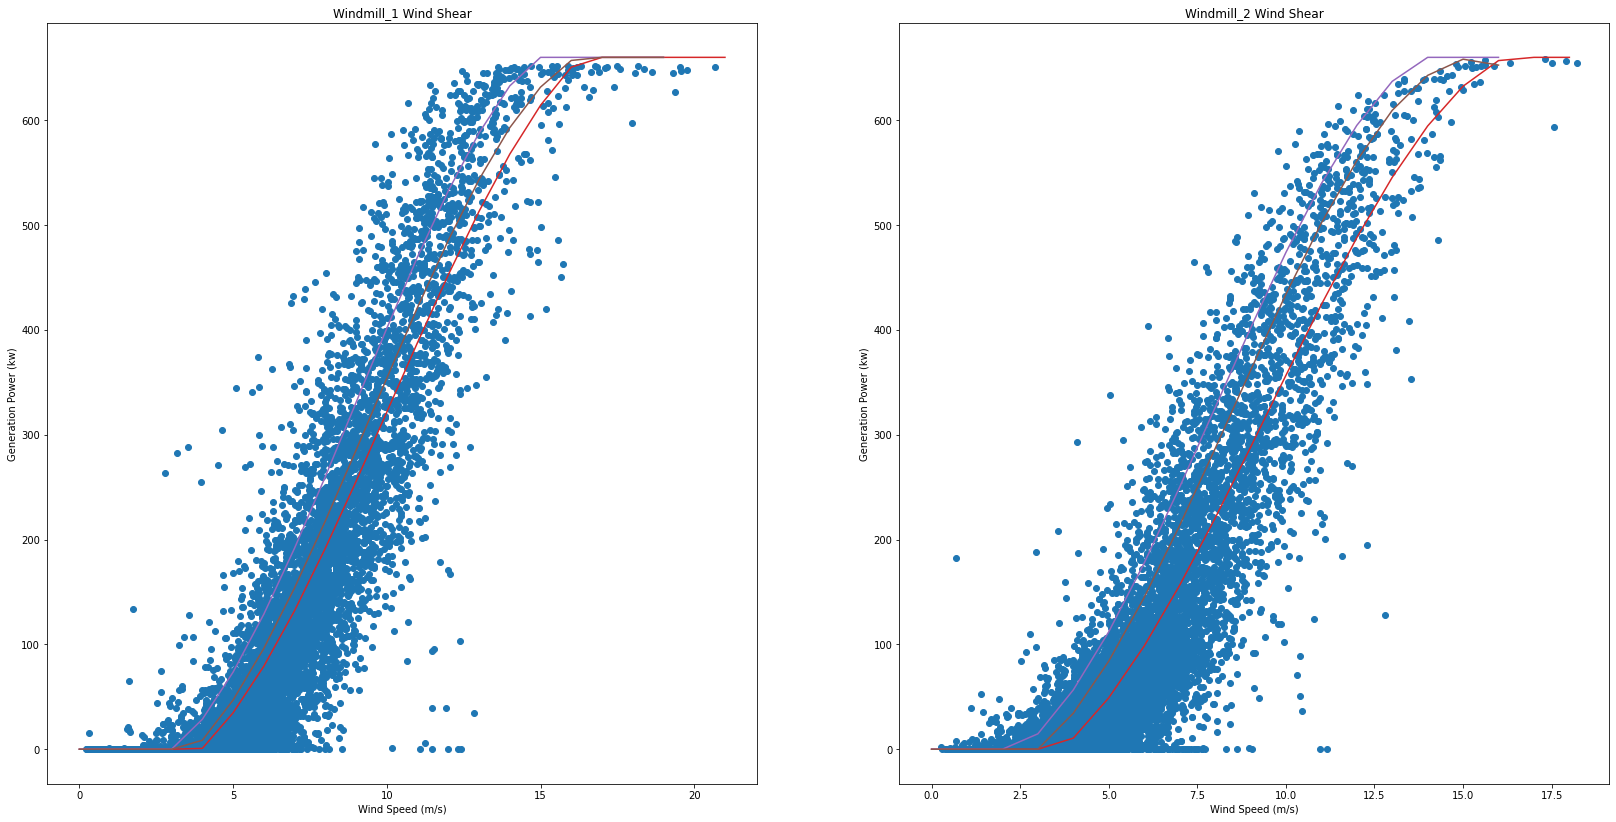

In [21]:
fig, axs = plt.subplots(nrows=1, ncols=2, figsize=(28, 14))

axs[0].set_title("Windmill_1 Wind Shear")
axs[0].scatter(df_1_wsr["hws_uv_wsr"], df_1_wsr["VAERDI"], color='C0')
axs[0].plot(df_1_wsr_qt["hws_uv_wsr"], df_1_wsr_qt["q0.5"], color='C3')
axs[0].plot(df_1_rn_qt["hws_uv_rn"], df_1_rn_qt["q0.5"], color='C4')
axs[0].plot(df_1_rn_qt["hws_uv_rn"], df_1_rn_qt["q0.3"], color='C5')
axs[0].set_xlabel("Wind Speed (m/s)")
axs[0].set_ylabel("Generation Power (kw)")

axs[1].set_title("Windmill_2 Wind Shear")
axs[1].scatter(df_2_wsr["hws_uv_wsr"], df_2_wsr["VAERDI"], color='C0')
axs[1].plot(df_2_wsr_qt["hws_uv_wsr"], df_2_wsr_qt["q0.5"], color='C3')
axs[1].plot(df_2_rn_qt["hws_uv_rn"], df_2_rn_qt["q0.5"], color='C4')
axs[1].plot(df_2_rn_qt["hws_uv_rn"], df_2_rn_qt["q0.3"], color='C5')
axs[1].set_xlabel("Wind Speed (m/s)")
axs[1].set_ylabel("Generation Power (kw)")


In [ ]:
quantiles = [0.1, 0.3, 0.5, 0.7, 0.9]
aggs = {"VAERDI" : [lambda x :x.quantile(i) for i in quantiles]}
new_plt = df_plt.groupby("hws_uv_wsr_rnd", as_index=False).agg(aggs)
new_plt = pd.DataFrame(new_plt.values, columns = ["hws_uv_wsr_rnd", "q0.1", "q0.3", "q0.5", "q0.7", "q0.9"])

In [ ]:
new_plt_1 = df_plt.groupby("hws_uv_rn_rnd", as_index=False).agg(aggs)
new_plt_1 = pd.DataFrame(new_plt_1.values, columns = ["hws_uv_rn_rnd", "q0.1", "q0.3", "q0.5", "q0.7", "q0.9"])

In [ ]:
new_plt_2 = df_plt.groupby("hws_uv_geo_rnd", as_index=False).agg(aggs)
new_plt_2 = pd.DataFrame(new_plt_2.values, columns = ["hws_uv_geo_rnd", "q0.1", "q0.3", "q0.5", "q0.7", "q0.9"])

In [ ]:
plt.figure(figsize=(10,10))
plt.scatter(df_plt["hws_uv_wsr_rnd"], df_plt["VAERDI"], alpha=0.2, label="Wind Shear")
# plt.plot(new_plt["hws_uv_wsr_rnd"], new_plt["q0.1"], linewidth=2)
# plt.plot(new_plt["hws_uv_wsr_rnd"], new_plt["q0.3"], linewidth=2)
plt.plot(new_plt["hws_uv_wsr_rnd"], new_plt["q0.5"], linewidth=2, color="k")
plt.plot(new_plt_1["hws_uv_rn_rnd"], new_plt_1["q0.5"], linewidth=2, color="g")
plt.plot(new_plt_2["hws_uv_geo_rnd"], new_plt_2["q0.5"], linewidth=2, color="r")
# plt.plot(new_plt["hws_uv_wsr_rnd"], new_plt["q0.7"], linewidth=2)
# plt.plot(new_plt["hws_uv_wsr_rnd"], new_plt["q0.9"], linewidth=2)
plt.show()

In [ ]:
from sklearn.preprocessing import PolynomialFeatures
from sklearn.linear_model import Ridge
from sklearn.pipeline import make_pipeline

X = new_plt["hws_uv_wsr_rnd"].values.reshape(-1, 1)
y = new_plt["q0.3"]
model_q0_3 = make_pipeline(PolynomialFeatures(3), Ridge())
model_q0_3.fit(X, y)
y = new_plt["q0.5"]
model_q0_5 = make_pipeline(PolynomialFeatures(3), Ridge())
model_q0_5.fit(X, y)
y = new_plt["q0.7"]
model_q0_7 = make_pipeline(PolynomialFeatures(3), Ridge())
model_q0_7.fit(X, y)

new_plt["q0.3"] = pd.Series(model_q0_3.predict(X))
new_plt["q0.5"] = pd.Series(model_q0_5.predict(X))
new_plt["q0.7"] = pd.Series(model_q0_7.predict(X))

In [ ]:
ys = [new_plt["q0.1"], new_plt["q0.5"], new_plt["q0.9"]]
X = new_plt["hws_uv_wsr_rnd"].values.reshape(-1, 1)
ploynomial_quantile_windpower_curves(X, ys, scatterplt=[df_plt["hws_uv_wsr_rnd"], df_plt["VAERDI"]], boundary=[0, 660])